# Feature extraction and EDA for the enaged classification problem 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.style as style
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
import seaborn as sns
style.use('ggplot')
from IPython.display import display, HTML
from pylab import rcParams
%matplotlib inline

## Load the users dataset
Create two new columns `days_since_creation` days since user created and the user `age` in years.

In [2]:
users = pd.read_csv("data/rev-users.csv")
users['created_date'] = pd.to_datetime(users['created_date'])
devices = pd.read_csv("data/rev-devices.csv")
users = users.merge(devices, on="user_id", how="left")
users["age"] = users.birth_year.apply(lambda x: (2020 - x))
users["days_since_creation"] = users.created_date.apply(
    lambda x: ((users.created_date.max() - x).days))
users.head()

,user_id,birth_year,country,city,created_date,user_settings_crypto_unlocked,plan,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,num_referrals,num_successful_referrals,brand,age,days_since_creation
0,user_0,1989,PL,Gdansk,2018-01-13 05:15:15.599466,1,STANDARD,1.0,1.0,3,0,0,Apple,31,355
1,user_1,1975,GB,London,2018-01-29 03:38:46.676876,0,STANDARD,NaN,NaN,21,0,0,Apple,45,339
2,user_2,1987,PL,Poznań,2018-01-18 19:17:31.229096,0,STANDARD,0.0,0.0,21,0,0,Android,33,349
3,user_3,1994,FR,Paris,2018-01-15 18:47:56.723104,0,STANDARD,1.0,0.0,0,0,0,Apple,26,352
4,user_4,1985,GB,Beckenham,2018-01-11 00:36:46.673673,0,STANDARD,NaN,NaN,2,0,0,Apple,35,357


### Some value counts of the relevant features

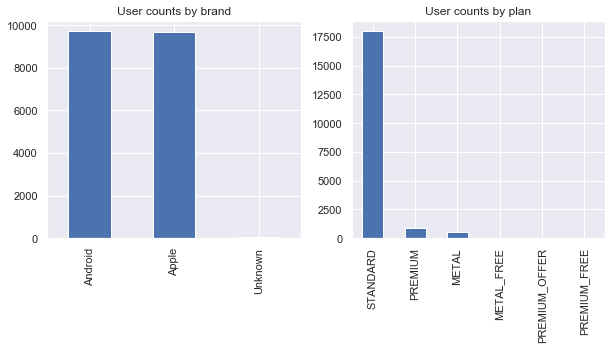

In [3]:
sns.set(rc={'figure.figsize': (10, 4)})
fig, axes = plt.subplots(nrows=1, ncols=2)
users.brand.value_counts(dropna=False).plot(
    kind="bar", ax=axes[0]).set_title("User counts by brand")
txt = users.plan.value_counts(dropna=False).plot(
    kind="bar", ax=axes[1]).set_title("User counts by plan")

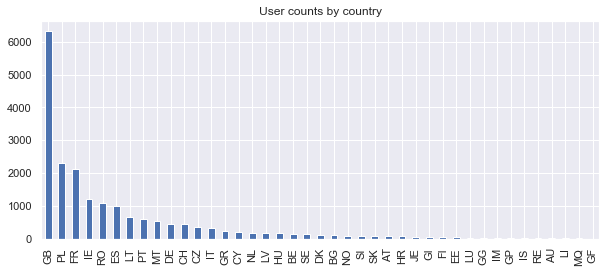

In [4]:
sns.set(rc={'figure.figsize': (10, 4)})
fig, axes = plt.subplots(nrows=1, ncols=1)
txt = users.country.value_counts(dropna=False).plot(
    kind="bar", ax=axes).set_title("User counts by country")

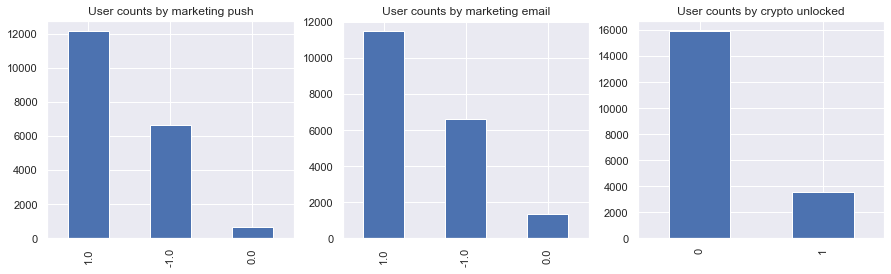

In [5]:
users[['attributes_notifications_marketing_push',
       'attributes_notifications_marketing_email']] = users[['attributes_notifications_marketing_push',
                                                             'attributes_notifications_marketing_email']].fillna(value=-1)

sns.set(rc={'figure.figsize': (15, 4)})


fig, axes = plt.subplots(nrows=1, ncols=3)
users.attributes_notifications_marketing_push.value_counts(
    dropna=False).plot(
    kind="bar", ax=axes[0]).set_title("User counts by marketing push")
users.attributes_notifications_marketing_email.value_counts(
    dropna=False).plot(
    kind="bar", ax=axes[1]).set_title("User counts by marketing email")

text=users.user_settings_crypto_unlocked.value_counts(
    dropna=False).plot(
    kind="bar", ax=axes[2]).set_title("User counts by crypto unlocked")

### Extract the number of users per city and country
The intution behind this feature is that more users in country/city implies greater user enagagement since the community would be larger.

In [6]:
# sns.set(rc={'figure.figsize': (12, 4)})
# fig, axes = plt.subplots(nrows=1, ncols=1)
# txt = users.city.value_counts(dropna=False).plot(
#     kind="bar", ax=axes).set_title("User counts by city")
counts_country = users.country.value_counts().reset_index()
counts_country.rename(
    columns={"country": "country_counts", "index": "country"}, inplace=True)
counts_city = users.city.value_counts().reset_index()
counts_city.rename(columns={"city": "city_counts",
                            "index": "city"}, inplace=True)
counts_city.head()

,city,city_counts
0,London,1707
1,Warszawa,414
2,Paris,373
3,Dublin,367
4,Vilnius,319


In [7]:
users =users.merge(counts_country, how="inner", on="country")
users =users.merge(counts_city, how="inner", on="city")

## Notifications
Read the notifications dataset and extract some aggregate metrics for the users.

In [8]:
notifications = pd.read_csv("data/rev-notifications.csv")
notifications['created_date'] = pd.to_datetime(notifications['created_date'])
print(notifications.shape)
notifications.head()

(121813, 5)


,reason,channel,status,user_id,created_date
0,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_7086,2018-12-02 17:58:33.320645
1,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_6598,2018-12-01 23:09:37.367127
2,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_4151,2018-12-04 02:57:56.425660
3,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_1408,2018-12-11 02:04:46.284683
4,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_6292,2018-12-14 17:09:58.900808


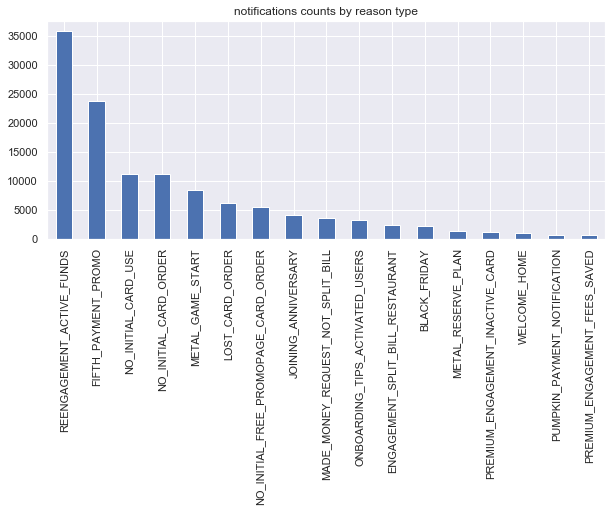

In [9]:
sns.set(rc={'figure.figsize': (10, 4)})
fig, axes = plt.subplots()
txt = notifications.reason.value_counts(dropna=False).plot(
    kind="bar", ax=axes).set_title("notifications counts by reason type")

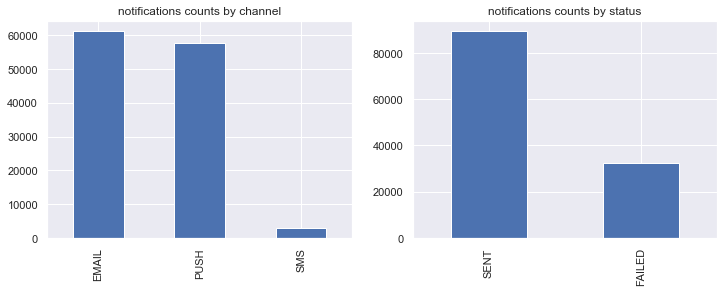

In [10]:
sns.set(rc={'figure.figsize': (12, 4)})
fig, axes = plt.subplots(nrows=1, ncols=2)
notifications.channel.value_counts(dropna=False).plot(
    kind="bar", ax=axes[0]).set_title("notifications counts by channel")
txt = notifications.status.value_counts(dropna=False).plot(
    kind="bar", ax=axes[1]).set_title("notifications counts by status")

### Aggregate metrics per user
* Number of days since last notification.
* Number of notifications sent to user.
* The count of types of notifications sent to a user.
* I do not have clear picture on the type of notification sent but I am making an (un)educated guess on counting the number of reengagement notifications and and the number of no initial card user and no initial card order the latter two probably implying unenaged users.

In [11]:
last_notification_date = notifications.created_date.max()


def notification_stats_by_user(group):
    days_since_last_notif = (
        last_notification_date - group[group.status.isin(["SENT"])].created_date.max()).days
    return pd.Series({"days_since_last_sent_notif": days_since_last_notif,
                      "number_of_notifs": len(group),
                      "number_of_emails": len(group[group.channel == "EMAIL"]),
                      "number_of_push": len(group[group.channel == "PUSH"]),
                      "number_of_sms": len(group[group.channel == "SMS"]),
                      "number_failed_notif": len(group[group.status == "SENT"]),
                      "number_sent_notif": len(group[group.status == "FAILED"]),
                      "number_reengagement_notif": len(group[group.reason == "REENGAGEMENT_ACTIVE_FUNDS"]),
                      "number_no_card_notif": len(group[group.reason.isin(["NO_INITIAL_CARD_USE", "NO_INITIAL_CARD_ORDER"])])

                      })


notification_stats_user = notifications.groupby("user_id").apply(
    notification_stats_by_user)
notification_stats_user.head()

,days_since_last_sent_notif,number_of_notifs,number_of_emails,number_of_push,number_of_sms,number_failed_notif,number_sent_notif,number_reengagement_notif,number_no_card_notif
user_id,,,,,,,,,
user_0,74.0,8.0,2.0,6.0,0.0,8.0,0.0,3.0,0.0
user_1,83.0,7.0,4.0,3.0,0.0,2.0,5.0,1.0,3.0
user_10,63.0,6.0,3.0,3.0,0.0,6.0,0.0,0.0,0.0
user_100,72.0,4.0,2.0,2.0,0.0,4.0,0.0,0.0,0.0
user_1000,81.0,18.0,6.0,11.0,1.0,16.0,2.0,11.0,3.0


In [12]:
notification_stats_user.reset_index(inplace=True)
users = users.merge(notification_stats_user, how="left", on="user_id")

## The feature set for engaged user classification
The final labelled dataset for classifying engaged vs unengaed users.
I am remeving the columns `num_referrals` and `num_successful_referrals` which are 0s throughout. `birth_year`, `country`, `city`, `created_date` are also discared due to reasons such as high cardinality and having the feature `age` which is proxy for birth year.

In [13]:
unengaged_users = pd.read_csv("unengaged_users.csv")
unengaged_users["is_unengaged"] = 1

engaged_users = pd.read_csv("engaged_users.csv")
engaged_users["is_unengaged"] = 0

user_engagement = engaged_users.append(unengaged_users, ignore_index=True)
users = users.merge(user_engagement, how="left", on="user_id")
users.head()

,user_id,birth_year,country,city,created_date,user_settings_crypto_unlocked,plan,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,...,number_sent_notif,number_reengagement_notif,number_no_card_notif,number_of_trans,transaction_mean,transaction_min,transaction_max,completed_pending_count,other_state_count,is_unengaged
0,user_0,1989,PL,Gdansk,2018-01-13 05:15:15.599466,1,STANDARD,1.0,1.0,3,...,0.0,3.0,0.0,389.0,35.176787,0.0,582.18,350.0,39.0,0.0
1,user_888,1990,PL,Gdansk,2018-01-27 03:15:16.535043,1,STANDARD,-1.0,-1.0,15,...,0.0,2.0,0.0,141.0,27.217730,0.1,397.66,123.0,18.0,0.0
2,user_2273,1978,PL,Gdansk,2018-03-11 01:51:19.475354,0,PREMIUM,1.0,1.0,0,...,3.0,0.0,3.0,838.0,9.755334,0.0,198.83,487.0,351.0,0.0
3,user_2457,1970,PL,Gdansk,2018-03-27 06:56:45.598634,0,STANDARD,-1.0,-1.0,3,...,2.0,5.0,0.0,42.0,132.810952,0.0,1079.57,36.0,6.0,0.0
4,user_3747,1986,PL,Gdansk,2018-03-08 03:38:27.270720,0,STANDARD,1.0,1.0,13,...,5.0,1.0,7.0,260.0,67.492192,0.0,2445.63,193.0,67.0,0.0


In [14]:
print(users.num_referrals.max(),users.num_referrals.min())
users.num_successful_referrals.max(), users.num_successful_referrals.max()

0 0


(0, 0)

In [15]:
users = users.drop(["birth_year", "country", "city", "created_date",
                    "num_referrals", "num_successful_referrals"], axis=1)
users.to_csv("user_features.csv", index=False)